In [4]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{ "size":16}) #**{,,'serif':['Palatino']
rc('text', usetex=True)
import numpy.random as rnd
rnd.seed()
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
from scipy.optimize import brentq as solve
from scipy.integrate import odeint as ode
from scipy.special import gamma
np.set_printoptions(precision = 3, suppress = 1)
from matplotlib import cm
color = cm.get_cmap("Blues")

# Gaussian free field in two dimensions

The 2D Gaussian free field is defined by the action 

$$ S = \frac{g}{4\pi}\int  (\nabla \phi)^2 \mathrm{d}^2 x$$

where $g > 0$ is the coupling constant. It is logarithmically correlated, as one often writes:

$$ \left< \phi(0)\phi(x) \right> \sim  -\frac{1}{g} \ln |x|  $$

- Do we have a quick and dirty way to derive this? (*reminder* $\Delta  \ln |x| = 2\pi \delta^2(x) $)
- What does $\sim$ mean in the formula? To clarify that would one goal of this TD.

## Lattice GFF

Let us put the action on a square lattice of $N \times N$ sites, with a lattice spacing $a$. So the lattice describes a torus of size $L \times L$ with $L = N a$.

- Write down a lattice version of the action. 
- How to sample that on a computer? 

We will find that the statistical properties of the $N^2$-component Gaussian variable that the computer generates is **independent of $a$**, but only of $N$ and $g$. 

In [24]:
def get_kernel(N, g=4): 
    """prepare a kernel for 2D GFF """
    a = 2 * np.pi / N
    ps = np.arange(N) * 2 * np.pi / N
    ps, qs = np.meshgrid(ps, ps)
    kernel = 2 * (1 - np.cos(qs) + 1 - np.cos(ps)) * N**2 * g / np.pi / 2 #* (np.pi * 2) ** 2
    kernel[0,0] = 1
    kernel **= (- 1/2)
    kernel[0,0] = 0. 
    return kernel
def get_GFF(kernel):
    L = len(kernel)
    return  np.fft.fft2((rnd.randn(L,L) + rnd.randn(L,L) * 1.j)* kernel).real 

## Nice pictures first

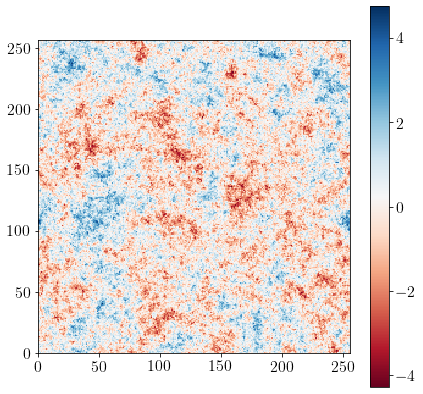

In [195]:
L = 2 ** 8
g = 4
kernel = get_kernel(L, g)
gff = get_GFF(kernel)
plt.figure(1,figsize=(7,7))
plt.pcolor(gff, cmap = "RdBu")
plt.gca().set_aspect("equal")
plt.colorbar()

## Green function

First let's benchmark the GFF generator is working correctly. After this we will compute the real-space Green function without sampling.



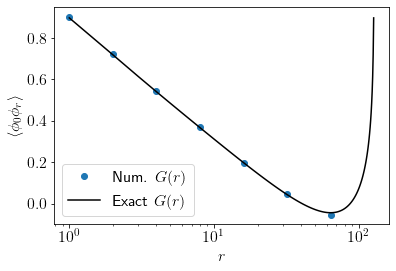

In [202]:
lb = 7
L = 2 ** lb
g = 4
kernel = get_kernel(L, g)
rs =2 ** np.arange(lb)
ans = np.zeros(len(rs)+1, dtype=float)
for j in range(100):
    gff = get_GFF(kernel)
    for i,r in enumerate(rs):
        ans[i+1] += np.mean(gff * np.roll(gff, r, axis = 0))
    ans[0] += 1
    


plt.plot(rs , ans[1:]/ans[0] , "o", label=r"Num. $G(r)$")
prediction = np.fft.fft2(kernel ** 2).real 
xs = np.arange(1, L)
plt.plot(xs , prediction[0, xs], "-", c = "k", label=r"Exact $G(r)$")
#plt.plot(xs, -1/g * np.log(xs), "--g", label=r"$-\frac{1}g \log |r|$")
plt.xscale("log")
plt.xlabel(r"$r$")
plt.ylabel(r"$\left< \phi_0 \phi_r \right>$")
plt.legend()

- Show that the Green function in a finite domain with IR cutoff $L$ and UV cutoff $\epsilon$ is 
$$ G(r) =- \frac1{g} \ln |r / L| + \mathrm{O}(1) \,,\,  \epsilon \gg |r| \gg L$$

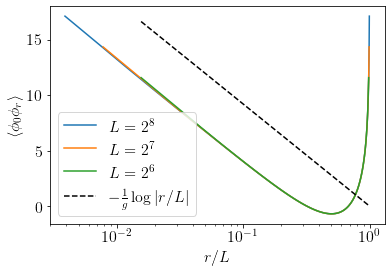

In [32]:
for lb in [8,7,6]:
    L = 2 ** lb
    g = 1/4
    kernel = get_kernel(L, g)

    prediction = np.fft.fft2(kernel ** 2).real 
    xs = np.arange(1, L)
    plt.plot(xs / L , prediction[0, xs], "-",  label=r"$L = 2^{%d}$" % lb)
plt.plot(xs / L, -1/g * np.log(xs / L), "--k", label=r"$-\frac{1}g \log |r / L|$")

plt.xscale("log")
plt.xlabel(r"$r / L$")
plt.ylabel(r"$\left< \phi_0 \phi_r \right>$")
plt.legend()

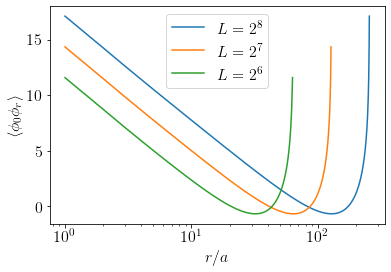

In [31]:
for lb in [8,7,6]:
    L = 2 ** lb
    g = 1/4
    kernel = get_kernel(L, g)

    prediction = np.fft.fft2(kernel ** 2).real 
    xs = np.arange(1, L)
    plt.plot(xs  , prediction[0, xs], "-",  label=r"$L = 2^{%d}$" % lb)
plt.xscale("log")
plt.xlabel(r"$r / a$")
plt.ylabel(r"$\left< \phi_0 \phi_r \right>$")
plt.legend()

## Vertex operators


- **Gaussian gymnastics** Let $\phi$ be some Gaussian vector with correlation matrix 
$$ \phi_i \phi_j = G_{ij} \,. $$
Show that 
$$  \left< \exp\left(\sum_{i} a_i \phi_i \right) \right> = \exp\left( \frac12 \sum_{ij} a_i G_{ij}  a_j \right) \,. $$
2

A (bare) vertex operator is defined as 
$$ V_a(z) := \exp(\mathrm{i} a \phi(z)) $$

- Compute the correlation function
$$  \left< V_{a_1}(x_1) V_{a_2}(x_2) \dots  V_{a_n}(x_n) \right> $$
where $\epsilon \ll |x_i - x_j| \ll L$. The answer should be the product of three factors: a power of $\epsilon$, powers of $|x_i - x_j|$'s, and a power of $L$. The power of $L$ vanishes if and only if $\sum_i a_i = 0$. Otherwise the correlation function vanishes in the limit $L\to \infty$. This is known as the charge neutrality condition. 

- What is the scaling dimension of $V_a$? When is $V_a$ relevant, irrelevant, marginal?

##  Fun application: a thermal particle in 2D GFF

Consider a thermal particle in a random potential which is given by a (discrete) 2D GFF. The partition function reads 
$$ Z = \sum_x \exp(-\beta \phi(x) )$$
where $\beta = 1/T$ is the inverse temperature.


- Note that this is a statistical physics model with *quenched* disorder. The quenched free energy is 
$$ F = - T \overline{\ln Z} $$ 
while the annealed mean free energy is
$$ F_a = - T \ln \overline{Z} $$
Can you compare them (show an inequality)? Which one is simpler to compute? 

- Do the simpler computation. What is the free energy per volume in the annealed approximation? Observe that it violates a basic principle of thermodynamics when $\beta$ is larger than a threshold value $\beta_c$.

- Based on the numerical data below, discuss what happens below and above $\beta_c$ respetively.

In [59]:
res_F = dict()

In [60]:
g = 1/4
betas = np.linspace(0, 2, 20)[1:]

for lb in [5,6,7]:
    L = 2 ** lb
    kernel = get_kernel(L, g)
    for j in range(100):
        gff = get_GFF(kernel)
        gmin = np.min(gff)
        for beta in betas:
            f = -np.log(np.sum(np.exp(-(gff-gmin) * beta)))/beta + gmin
            if not (beta,lb) in res_F: res_F[beta,lb]=[]
            res_F[beta, lb].append(f)

-66.63793703342006
-79.94445927414334
-93.28717762215737


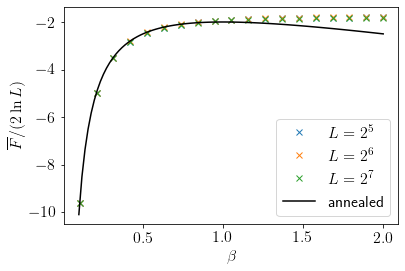

In [68]:
for lb in [5,6,7]:
    ys = np.array([np.mean(res_F[beta, lb]) for beta in betas])
    plt.plot(betas, ys / (lb * np.log(4)), "x", label= r"$L=2^{%d}$" % lb)
    print(ys[0])
xs = np.linspace(.1, 2, 100)
plt.plot(xs, (-xs-1/xs), c = "k", label="annealed" )
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\overline{F} / (2\ln L)$")
plt.legend()

What happens is a transition known as "freezing". When $\beta > \beta_c$, the thermal particle is trapped in the few minima of the potential and has zero entropy. Therefore the free energy becomes temperature independent. The freezing transition is one of the simplest glassy transition, and involves a one-step replica symmetry breaking.

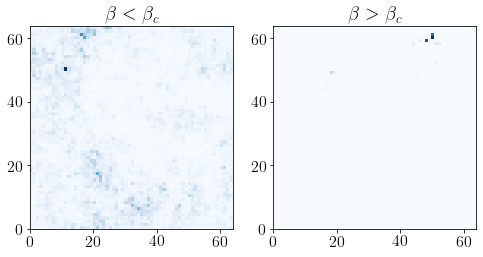

In [92]:
L = 2 ** 6
g = 1/4
kernel = get_kernel(L, g)

fig, ax = plt.subplots(1,2,figsize=(8,5))

for i,beta in enumerate([.2, 1.5]):
    
    gff = get_GFF(kernel)
    gmin = np.min(gff)
    Z = np.sum(np.exp(-(gff-gmin) * beta))
    gibbs = np.exp((gmin - gff) * beta) / Z
    plt.sca(ax[i])
    plt.pcolor(gibbs, cmap = "Blues")
    plt.gca().set_aspect("equal")
    plt.title(r"$\beta>\beta_c$" if i else r"$\beta<\beta_c$")
    #plt.colorbar()

